## Analysis after model training

- Plot training and validation loss, accuracy, precision, recall, f1, curves.
- Visualize some correctly and incorrectly classified images.
- Use Grad-CAM or similar techniques to interpret model predictions. # To be done

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import sys
import torch
import torchvision.transforms as transforms
from PIL import Image


### Load training log

In [2]:

# Load the JSON file
file_path = "../results/temp_training_log_20250112-181355.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Convert lists to DataFrame for plotting
df = pd.DataFrame(data)
df

,train_loss,train_precision,train_recall,train_f1,train_accuracy,train_auc,train_confusion_matrix,val_loss,val_precision,val_recall,val_f1,val_accuracy,val_auc,val_confusion_matrix
0,0.223187,0.908999,0.911765,0.910380,0.913701,0.969903,"[[1950, 180], [174, 1798]]",0.335374,0.998043,0.796875,0.886186,0.850627,0.990427,"[[236, 1], [130, 510]]"
1,0.146767,0.944954,0.950461,0.947700,0.947343,0.985954,"[[1929, 114], [102, 1957]]",0.310766,0.989324,0.868750,0.925125,0.897377,0.987803,"[[231, 6], [84, 556]]"
2,0.142753,0.946588,0.942857,0.944719,0.945392,0.986982,"[[1964, 108], [116, 1914]]",0.528981,0.991684,0.745313,0.851026,0.809578,0.985245,"[[233, 4], [163, 477]]"
3,0.114924,0.960236,0.952288,0.956245,0.956363,0.991509,"[[1967, 81], [98, 1956]]",0.386079,0.994465,0.842187,0.912014,0.881414,0.985799,"[[234, 3], [101, 539]]"


### Plots of Loss

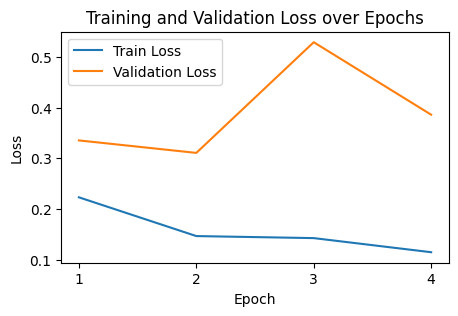

In [13]:
# Plot Loss
plt.figure(figsize=(5, 3))
num_epochs = len(df)  # Number of epochs in the dataset
plt.plot(range(1, num_epochs + 1), df['train_loss'], label='Train Loss')
plt.plot(range(1, num_epochs + 1), df['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.xticks(np.arange(1, num_epochs + 1, step=1))  # Start x-ticks at 1, go up to num_epochs
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()


### Plots of Precision, Recall, F1, and Accuracy

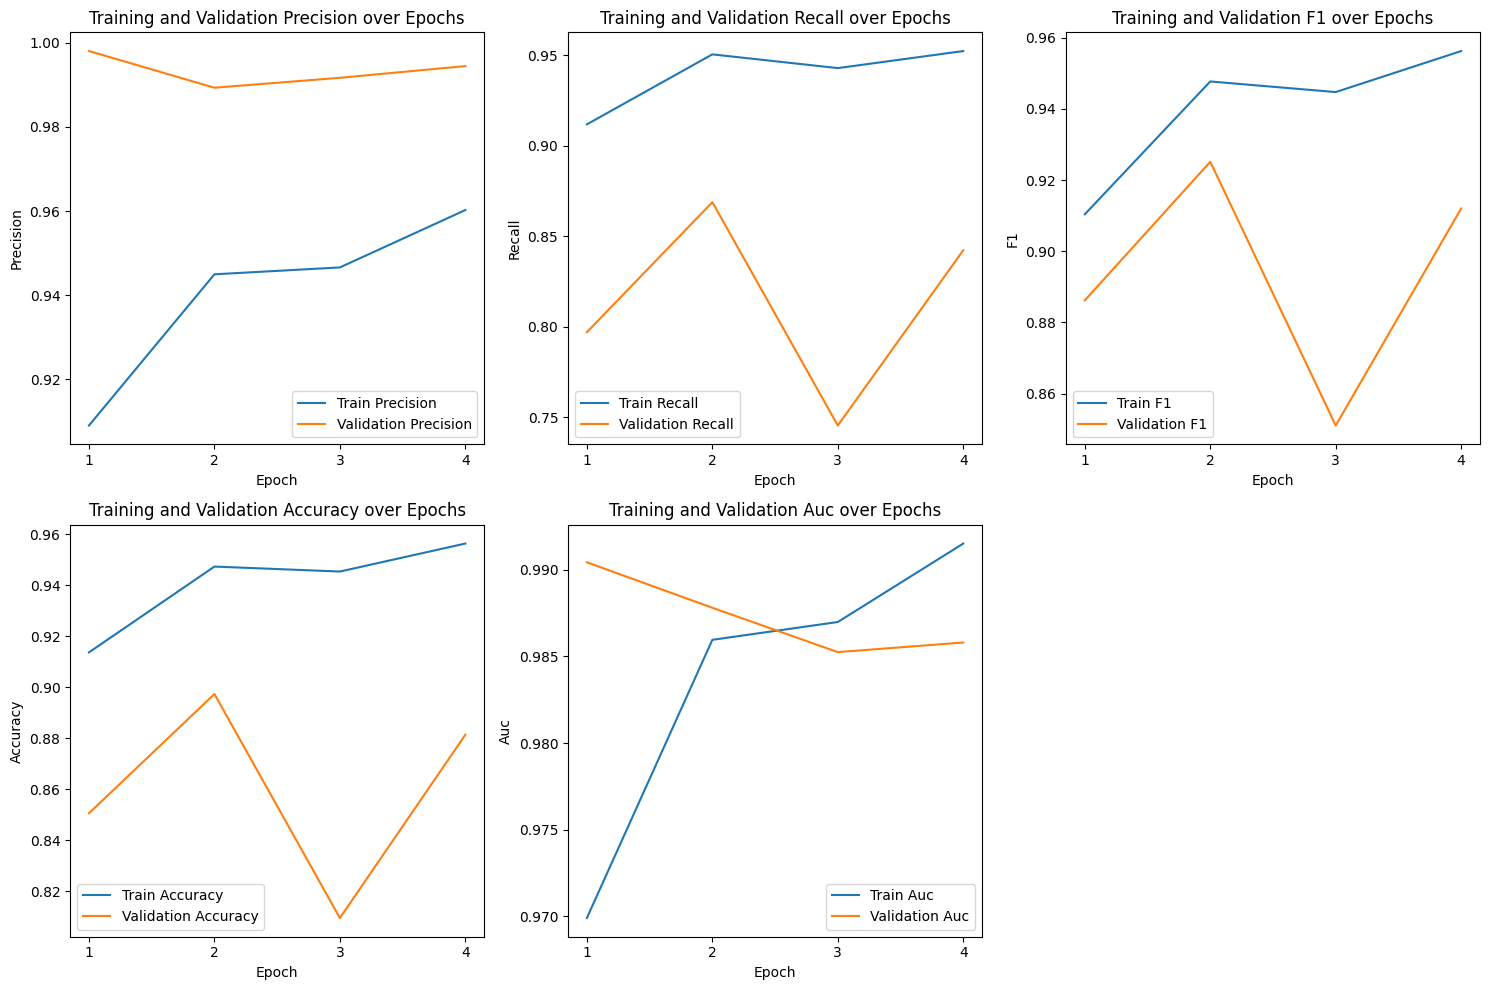

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Plot Precision, Recall, F1, Accuracy, and AUC in a 2-row, 3-column grid
metrics = ['precision', 'recall', 'f1', 'accuracy', 'auc']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns, total size of figure

num_epochs = len(df)  # Number of epochs in the dataset

for i, metric in enumerate(metrics):
    row, col = divmod(i, 3)  # Determine subplot row and column index
    ax = axes[row, col]  # Select the appropriate subplot
    
    ax.plot(range(1, num_epochs + 1), df[f'train_{metric}'], label=f'Train {metric.capitalize()}')
    ax.plot(range(1, num_epochs + 1), df[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
    
    ax.set_xlabel('Epoch')
    ax.set_xticks(np.arange(1, num_epochs + 1))  # Start x-ticks at 1, go up to num_epochs
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'Training and Validation {metric.capitalize()} over Epochs')
    ax.legend()

# Hide the empty subplot if number of metrics is less than 6
if len(metrics) < 6:
    fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()


### Confusion matrices 

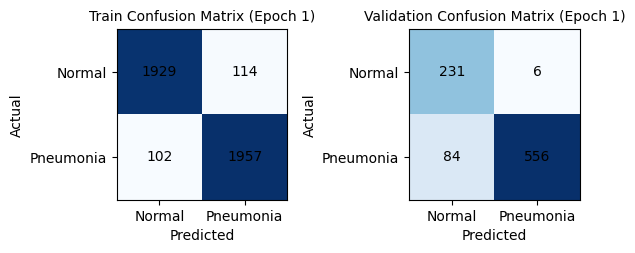

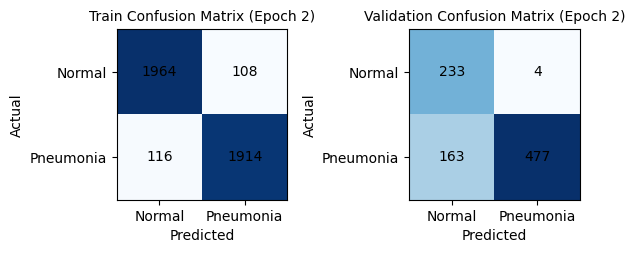

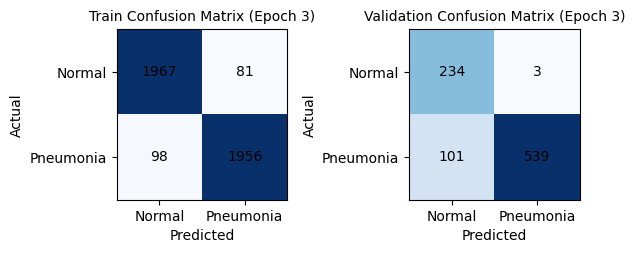

In [23]:
# Extract train and validation confusion matrices (NOTE: last three epochs)
train_conf_matrices = data['train_confusion_matrix'][-3:]
val_conf_matrices = data['val_confusion_matrix'][-3:]

# Function to plot a pair of confusion matrices side by side with labels
def plot_confusion_matrices(train_cm, val_cm, epoch):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))  # Create side-by-side plots
    class_names = ["Normal", "Pneumonia"]

    # Plot Train Confusion Matrix
    axes[0].imshow(train_cm, cmap='Blues')
    axes[0].set_title(f'Train Confusion Matrix (Epoch {epoch})', fontsize=10)
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_xticks([0, 1])
    axes[0].set_xticklabels(class_names)
    axes[0].set_yticks([0, 1])
    axes[0].set_yticklabels(class_names)
    
    # Annotate Train Confusion Matrix
    for (i, j), val in np.ndenumerate(train_cm):
        axes[0].text(j, i, f'{val}', ha='center', va='center')

    # Plot Validation Confusion Matrix
    axes[1].imshow(val_cm, cmap='Blues')
    axes[1].set_title(f'Validation Confusion Matrix (Epoch {epoch})', fontsize=10)
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    axes[1].set_xticks([0, 1])
    axes[1].set_xticklabels(class_names)
    axes[1].set_yticks([0, 1])
    axes[1].set_yticklabels(class_names)

    # Annotate Validation Confusion Matrix
    for (i, j), val in np.ndenumerate(val_cm):
        axes[1].text(j, i, f'{val}', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

# Plot train and validation confusion matrices side by side for each epoch
for i, (train_cm, val_cm) in enumerate(zip(train_conf_matrices, val_conf_matrices), 1):
    train_cm = np.array(train_cm)
    val_cm = np.array(val_cm)
    plot_confusion_matrices(train_cm, val_cm, epoch=i)


### Model summary

In [24]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import random
import sys

# Add parent directory to Python path
sys.path.append("C:/Users/glajusj/Documents/github/PneumoScope")

# Import PneumoNet from model.py
from src.model import PneumoNet

# Load the checkpoint
checkpoint_path = "../saved_models/best_model_20250112-015744.pth"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Initialize the model with num_classes=1 for binary classification
model = PneumoNet(num_classes=1)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set to evaluation mode

# Define preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

from torchsummary import summary
import torch
import torchvision.models as models
from IPython.display import display, Markdown

# Example: Assuming model is your instance of PneumoNet
summary_str = []  # List to store summary output as string

# Capture summary output
def capture_summary(model):
    from io import StringIO
    import sys

    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()
    
    summary(model, input_size=(3, 224, 224))
    
    sys.stdout = old_stdout
    return mystdout.getvalue()

# Get model summary as string
summary_output = capture_summary(model)

# Display as markdown
display(Markdown(f"```plaintext\n{summary_output}\n```"))


C:\Users\glajusj\AppData\Local\Temp\ipykernel_19832\643377671.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torc

```plaintext
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64, 56, 56]               0
           Conv2d-15           [-1, 64, 56, 56]          36,864
      BatchNorm2d-16           [-1, 64, 56, 56]             128
             ReLU-17           [-1, 64, 56, 56]               0
       BasicBlock-18           [-1, 64, 56, 56]               0
           Conv2d-19          [-1, 128, 28, 28]          73,728
      BatchNorm2d-20          [-1, 128, 28, 28]             256
             ReLU-21          [-1, 128, 28, 28]               0
           Conv2d-22          [-1, 128, 28, 28]         147,456
      BatchNorm2d-23          [-1, 128, 28, 28]             256
           Conv2d-24          [-1, 128, 28, 28]           8,192
      BatchNorm2d-25          [-1, 128, 28, 28]             256
             ReLU-26          [-1, 128, 28, 28]               0
       BasicBlock-27          [-1, 128, 28, 28]               0
           Conv2d-28          [-1, 128, 28, 28]         147,456
      BatchNorm2d-29          [-1, 128, 28, 28]             256
             ReLU-30          [-1, 128, 28, 28]               0
           Conv2d-31          [-1, 128, 28, 28]         147,456
      BatchNorm2d-32          [-1, 128, 28, 28]             256
             ReLU-33          [-1, 128, 28, 28]               0
       BasicBlock-34          [-1, 128, 28, 28]               0
           Conv2d-35          [-1, 256, 14, 14]         294,912
      BatchNorm2d-36          [-1, 256, 14, 14]             512
             ReLU-37          [-1, 256, 14, 14]               0
           Conv2d-38          [-1, 256, 14, 14]         589,824
      BatchNorm2d-39          [-1, 256, 14, 14]             512
           Conv2d-40          [-1, 256, 14, 14]          32,768
      BatchNorm2d-41          [-1, 256, 14, 14]             512
             ReLU-42          [-1, 256, 14, 14]               0
       BasicBlock-43          [-1, 256, 14, 14]               0
           Conv2d-44          [-1, 256, 14, 14]         589,824
      BatchNorm2d-45          [-1, 256, 14, 14]             512
             ReLU-46          [-1, 256, 14, 14]               0
           Conv2d-47          [-1, 256, 14, 14]         589,824
      BatchNorm2d-48          [-1, 256, 14, 14]             512
             ReLU-49          [-1, 256, 14, 14]               0
       BasicBlock-50          [-1, 256, 14, 14]               0
           Conv2d-51            [-1, 512, 7, 7]       1,179,648
      BatchNorm2d-52            [-1, 512, 7, 7]           1,024
             ReLU-53            [-1, 512, 7, 7]               0
           Conv2d-54            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-55            [-1, 512, 7, 7]           1,024
           Conv2d-56            [-1, 512, 7, 7]         131,072
      BatchNorm2d-57            [-1, 512, 7, 7]           1,024
             ReLU-58            [-1, 512, 7, 7]               0
       BasicBlock-59            [-1, 512, 7, 7]               0
           Conv2d-60            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-61            [-1, 512, 7, 7]           1,024
             ReLU-62            [-1, 512, 7, 7]               0
           Conv2d-63            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-64            [-1, 512, 7, 7]           1,024
             ReLU-65            [-1, 512, 7, 7]               0
       BasicBlock-66            [-1, 512, 7, 7]               0
AdaptiveAvgPool2d-67            [-1, 512, 1, 1]               0
           Linear-68                    [-1, 1]             513
           ResNet-69                    [-1, 1]               0
================================================================
Total params: 11,177,025
Trainable params: 11,177,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 62.79
Params size (MB): 42.64
Estimated Total Size (MB): 106.00
----------------------------------------------------------------

```

### Heatmap inference 

Displaying correctly classified images:


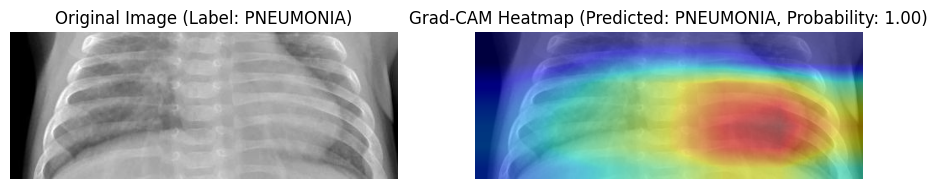

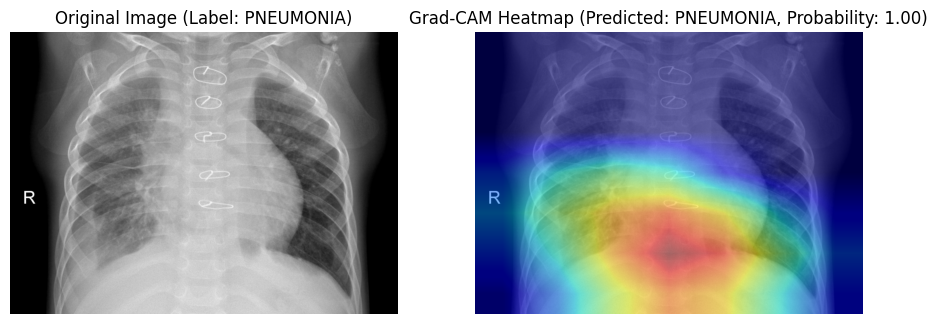

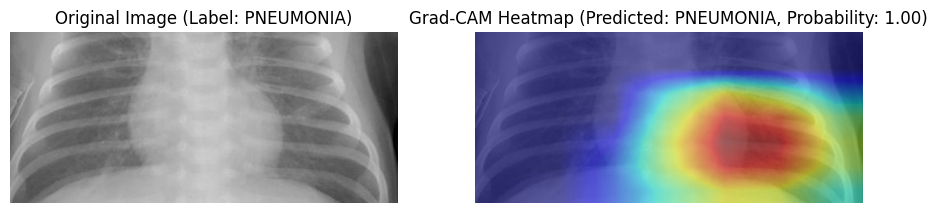

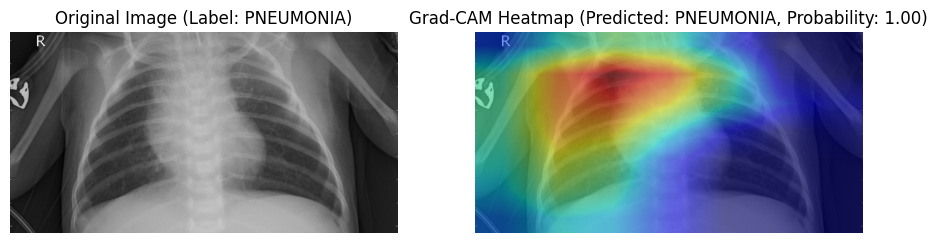

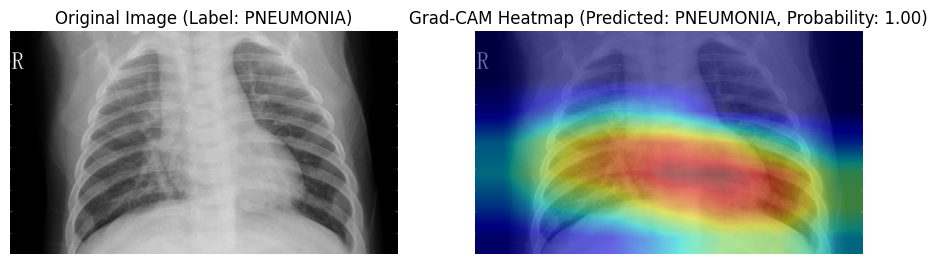

Displaying incorrectly classified images:


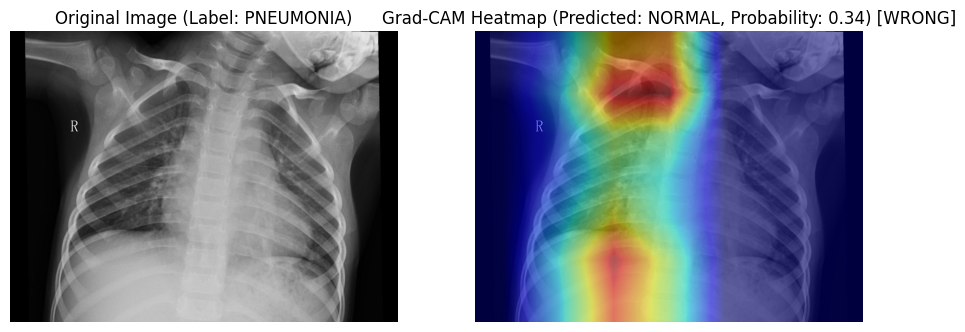

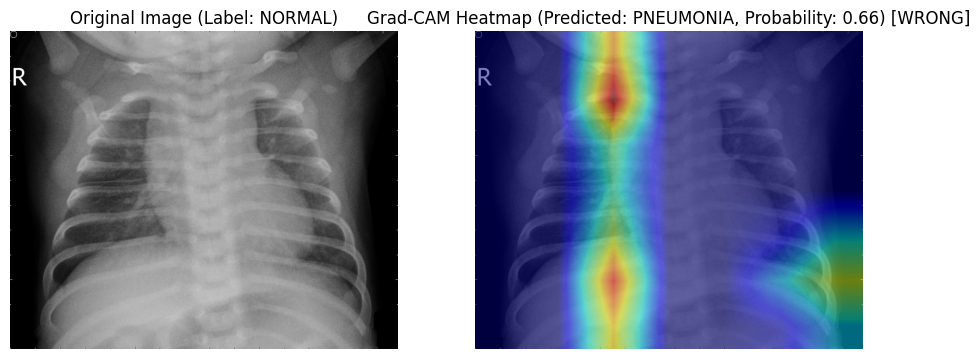

In [26]:

# Class labels
class_labels = {0: "NORMAL", 1: "PNEUMONIA"}

# Function to register hooks for Grad-CAM
def register_hooks(model):
    gradients = []  # To store gradients from the backward pass

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])  # Store the gradient of the output wrt. input
    
    def forward_hook(module, input, output):
        global activations
        activations = output  # Store the forward pass activations

    # Register hooks on the last convolutional layer
    target_layer = model.base_model.layer4[-1].conv2
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    return gradients

# Function to apply Grad-CAM
def apply_gradcam(image_path, model, transform, label, correct_prediction):
    global activations  # Declare global to store activations
    gradients = register_hooks(model)  # Register hooks

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Forward pass
    output = model(input_tensor)
    probability = torch.sigmoid(output).item()
    predicted_class = 1 if probability >= 0.5 else 0

    # Backward pass
    model.zero_grad()  # Zero out previous gradients
    output.backward()  # Compute gradients w.r.t. the output

    # Get activations and gradients
    grad = gradients[0].cpu().numpy()  # Gradients from backward hook
    act = activations.detach().cpu().numpy()[0]  # Detach activations before converting to NumPy

    # Compute Grad-CAM
    weights = np.mean(grad, axis=(1, 2))  # Average the gradients spatially
    gradcam = np.zeros(act.shape[1:], dtype=np.float32)  # Initialize heatmap

    for i, w in enumerate(weights):
        gradcam += w * act[i]  # Weight the activation maps

    gradcam = np.maximum(gradcam, 0)  # ReLU to keep only positive values
    gradcam = gradcam / gradcam.max()  # Normalize heatmap

    # Resize heatmap to match the original image size
    gradcam = Image.fromarray(np.uint8(255 * gradcam)).resize(image.size, Image.BILINEAR)
    heatmap = np.array(gradcam)

    # Apply colormap (jet) to heatmap
    heatmap_colored = plt.cm.jet(heatmap / 255.0)[:, :, :3]  # Normalize and apply colormap
    heatmap_colored = np.uint8(255 * heatmap_colored)

    # Blend heatmap with original image
    overlay = np.uint8(np.array(image) * 0.5 + heatmap_colored * 0.5)

    # Display the results
    plt.figure(figsize=(11, 5.5))
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image (Label: {class_labels[label]})")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    title = f"Grad-CAM Heatmap (Predicted: {class_labels[predicted_class]}, Probability: {probability:.2f})"
    if not correct_prediction:
        title += " [WRONG]"
    plt.title(title)
    plt.imshow(overlay)
    plt.axis('off')
    
    plt.show()

# Paths to directories
pneumonia_dir = "../data/val/PNEUMONIA"
normal_dir = "../data/val/NORMAL"

# Collect correctly and incorrectly classified images
correct_images = []
incorrect_images = []

# Function to evaluate predictions and classify images
def classify_images(image_dir, label, num_images=100):
    global correct_images, incorrect_images
    images = random.sample(os.listdir(image_dir), num_images)

    for img_name in images:
        image_path = os.path.join(image_dir, img_name)
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0)

        with torch.no_grad():
            output = model(input_tensor)
            probability = torch.sigmoid(output).item()
            predicted_class = 1 if probability >= 0.5 else 0

        if predicted_class == label:
            correct_images.append((image_path, label))
        else:
            incorrect_images.append((image_path, label))

# Classify images in both directories
classify_images(pneumonia_dir, label=1)
classify_images(normal_dir, label=0)

# Select 5 correctly classified and 5 incorrectly classified images
correct_images = correct_images[:5]
incorrect_images = incorrect_images[:5]

# Apply Grad-CAM on correctly classified images
print("Displaying correctly classified images:")
for image_path, label in correct_images:
    apply_gradcam(image_path, model, transform, label, correct_prediction=True)

# Apply Grad-CAM on incorrectly classified images
print("Displaying incorrectly classified images:")
for image_path, label in incorrect_images:
    apply_gradcam(image_path, model, transform, label, correct_prediction=False)